# Notebook for the RL demonstration

In [2]:
from blockulib.experiments import test_playing_loop_timing
from blockulib.pipelines import Configs
from blockulib.playing import play_games, RandomLoop, YEstimator
from blockulib.utils import DeepList, ShallowList
from blockulib.data import NMostPopular
import torch

# Initial Data
Before including any model in the loop, we will first establish a baseline value function for each position - the expected game lenbgth, from that position, when acting according to a random policy.

## Possible states
First, we need to get a grasp of the possible boards state, that our model will be trained on. For that, let's play approx. $2^{15}$ games according to a random policy, to get a diverse collection of possible states.

Playing 1 games at once 8 times took 0.04761700000381097: ratio of 5.952125e-03 s/game
Playing 2 games at once 8 times took 0.061823500000173226: ratio of 3.863969e-03 s/game
Playing 4 games at once 8 times took 0.08971590000146534: ratio of 2.803622e-03 s/game
Playing 8 games at once 8 times took 0.14673469999979716: ratio of 2.292730e-03 s/game
Playing 16 games at once 8 times took 0.2546468000000459: ratio of 1.989428e-03 s/game
Playing 32 games at once 8 times took 0.4585099000032642: ratio of 1.791054e-03 s/game
Playing 64 games at once 8 times took 0.8720123000020976: ratio of 1.703149e-03 s/game
Playing 128 games at once 8 times took 1.717309400002705: ratio of 1.677060e-03 s/game
Playing 256 games at once 8 times took 3.6929841000019223: ratio of 1.803215e-03 s/game
Playing 512 games at once 8 times took 8.997845900004904: ratio of 2.196740e-03 s/game
Playing 1024 games at once 8 times took 24.614318799998728: ratio of 3.004678e-03 s/game


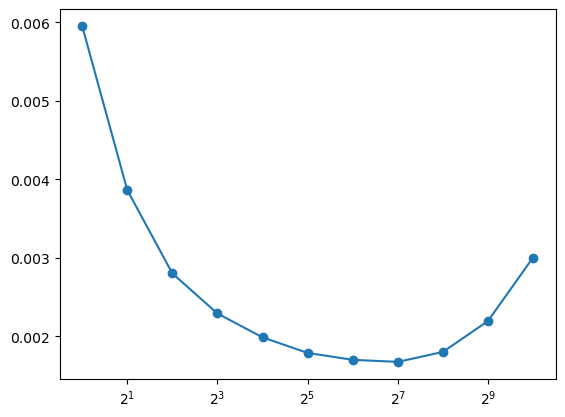

Best ratio achieved for 128 games at once with a ratio of 1.677060e-03 s/game


Playing games: 100%|██████████| 256/256 [00:52<00:00,  4.85it/s]


Mean MPG : 15.4530029296875


In [6]:
games_at_once = test_playing_loop_timing(RandomLoop, max_exp = 10, pos_list_type  = DeepList)

play_games_config = Configs.play_random_config(num_games = 32768, games_at_once = games_at_once, save = True)
play_games(**play_games_config)

Then we filter out the $2^{15}$ most frequently visited states among all the games

In [8]:
n_most_popular_config = Configs.n_most_popular_config(top_n = 32768)
x_transform = NMostPopular()
x_transform(**n_most_popular_config)

32768 boards requested, out of 474895
Threshold set at 2, 30180 places left


## Estimating Random Policy's value function
Now, we can try estimating the value function, of each of the selected $2^{15}$ boards.  
To do that, let's launch 128 different games from each position, and average out the rewards from all games.

Playing 1 games at once 8 times took 0.04716789999656612: ratio of 5.895987e-03 s/game
Playing 2 games at once 8 times took 0.059300499997334555: ratio of 3.706281e-03 s/game
Playing 4 games at once 8 times took 0.08970080000290181: ratio of 2.803150e-03 s/game
Playing 8 games at once 8 times took 0.15497099999629427: ratio of 2.421422e-03 s/game
Playing 16 games at once 8 times took 0.26577499999984866: ratio of 2.076367e-03 s/game
Playing 32 games at once 8 times took 0.5452874000038719: ratio of 2.130029e-03 s/game
Playing 64 games at once 8 times took 0.8699677000040538: ratio of 1.699156e-03 s/game
Playing 128 games at once 8 times took 1.5783184000028996: ratio of 1.541327e-03 s/game
Playing 256 games at once 8 times took 3.120798600000853: ratio of 1.523827e-03 s/game
Playing 512 games at once 8 times took 7.829263400002674: ratio of 1.911441e-03 s/game
Playing 1024 games at once 8 times took 24.262045199997374: ratio of 2.961675e-03 s/game


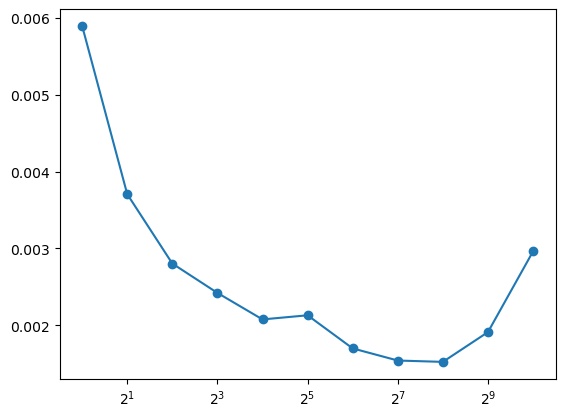

Best ratio achieved for 256 games at once with a ratio of 1.523827e-03 s/game


In [10]:
games_per_board = 128
games_at_once = max(test_playing_loop_timing(RandomLoop, max_exp = 10, pos_list_type  = ShallowList), games_per_board)

In [6]:
estimator = YEstimator(games_at_once = games_at_once, games_per_board = games_per_board)
estimator(loop_type = RandomLoop)

2 boards will be processed at once, with 128 games per board (256 games at once)


Estimating ys: 100%|██████████| 16384/16384 [43:00<00:00,  6.35it/s] 
